In [198]:
import torch
from torch import nn
import torchvision

import matplotlib.pyplot as plt
from torchmetrics import ConfusionMatrix, Accuracy
from mlxtend.plotting import plot_confusion_matrix
from tqdm import tqdm

In [199]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [200]:
train_data = torchvision.datasets.MNIST(
    "data", transform=torchvision.transforms.ToTensor(), download=True
)
test_data = torchvision.datasets.MNIST(
    "data", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


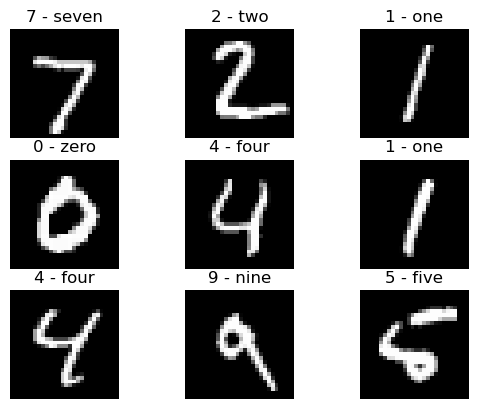

In [201]:
for i in range(9):
    image, label = test_data[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.axis("off")
    plt.title(train_data.classes[label])


In [202]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=batch_size, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=batch_size, shuffle=True
)


In [203]:
class MNISTModel(nn.Module):
    def __init__(
        self, in_shape, hidden_units, out_shape, kernel_size=3, stride=1, padding=1
    ):
        super().__init__()
        self.stack_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_shape,
                out_channels=hidden_units,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.MaxPool2d(kernel_size=2),
        )
        self.stack_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.MaxPool2d(kernel_size=2),
        )
        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 7 * 7, out_shape),
        )

    def forward(self, x):
        x = self.stack_1(x)
        x = self.stack_2(x)
        return self.output(x)


model = MNISTModel(1, 10, len(train_data.classes)).to(device)

In [204]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
acc_fn = Accuracy(task="multiclass", num_classes=len(train_data.classes)).to(device)


def print_metrics(loss, acc):
    print(f"Loss: {loss:.3f} | Acc: {acc * 100:.0f}%")


def train_step(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    device: torch.device = device,
):
    model.train()
    total_loss = 0
    total_acc = 0
    for X, y in tqdm(data_loader, desc="Training"):
        X, y = X.to(device), y.to(device)
        y_preds = model(X)
        loss = loss_fn(y_preds, y)
        total_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_acc += acc_fn(y_preds.squeeze(0).argmax(1), y)
    total_acc /= len(data_loader)
    total_loss /= len(data_loader)
    print_metrics(total_loss, total_acc)


def test_step(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    device: torch.device = device,
):
    model.eval()
    total_loss = 0
    total_acc = 0
    with torch.inference_mode():
        for X, y in tqdm(data_loader, desc="Testing"):
            X, y = X.to(device), y.to(device)
            y_preds = model(X)
            loss = loss_fn(y_preds, y)
            total_loss += loss
            total_acc += acc_fn(y_preds.squeeze(0).argmax(1), y)

        total_acc /= len(data_loader)
        total_loss /= len(data_loader)
        print_metrics(total_loss, total_acc)


epochs = 2
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_step(model, train_dataloader)
    test_step(model, test_dataloader)

Epoch 1/2


Training: 100%|██████████| 1875/1875 [00:07<00:00, 255.05it/s]


Loss: 0.201 | Acc: 94%


Testing: 100%|██████████| 313/313 [00:00<00:00, 356.08it/s]


Loss: 0.068 | Acc: 98%
Epoch 2/2


Training: 100%|██████████| 1875/1875 [00:07<00:00, 243.28it/s]


Loss: 0.078 | Acc: 98%


Testing: 100%|██████████| 313/313 [00:00<00:00, 346.37it/s]

Loss: 0.057 | Acc: 98%


In [205]:
model.eval()
with torch.inference_mode():
    X, y_targets = next(iter(test_dataloader))
    X, y_targets = X.to(device), y_targets
    y_logits = model(X)
    y_pred = y_logits.squeeze(0).argmax(1).cpu()


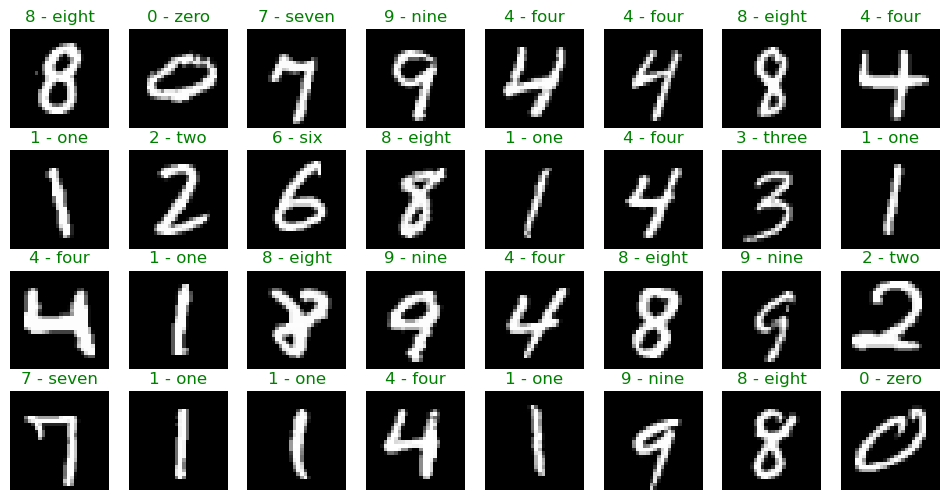

In [206]:
nrows, ncols = 4, 8
plt.figure(figsize=(ncols * 1.5, nrows * 1.5))
X = X.cpu()
for i in range(batch_size):
    plt.subplot(nrows, ncols, i + 1)
    plt.axis(False)
    plt.imshow(X[i].squeeze(), cmap="gray")
    c = "g" if y_pred[i] == y_targets[i] else "r"
    plt.title(f"{train_data.classes[y_pred[i]]}", c=c)


In [207]:
preds = []
target = []
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making Predictions"):
        X = X.to(device)
        y_pred = model(X).cpu()
        preds.append(y_pred.squeeze(1).argmax(1))
        target.append(y)

preds = torch.cat(preds)
target = torch.cat(target)


Making Predictions: 100%|██████████| 313/313 [00:00<00:00, 455.11it/s]


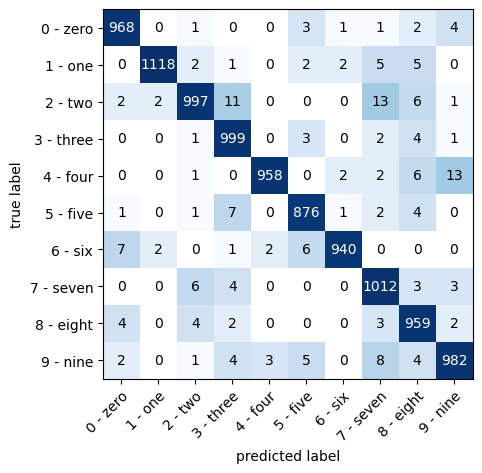

In [209]:
import matplotlib


conf_matrix = ConfusionMatrix(task="multiclass", num_classes=len(train_data.classes))
confmat_tensor = conf_matrix(preds, target)

plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=train_data.classes,
    norm_colormap=matplotlib.colors.LogNorm(),
)
plt.show()